<a href="https://colab.research.google.com/github/bineee39/first-repository/blob/master/NLP/DS6_%EB%89%B4%EC%8A%A4%EC%B9%B4%ED%85%8C%EA%B3%A0%EB%A6%AC_%EB%8B%A4%EC%A4%91%EB%B6%84%EB%A5%98%5B%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8%5D_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 회고

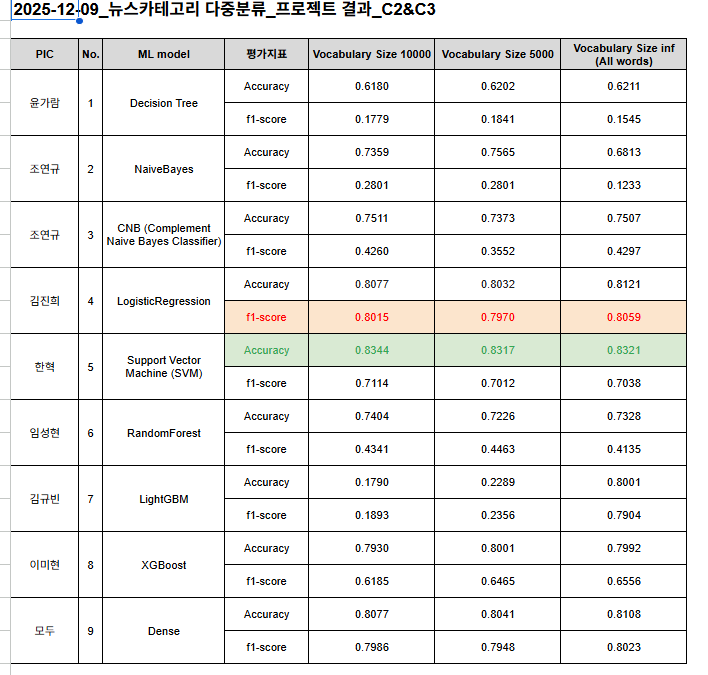

제가 맡은 모델은 lightGBM이었고, 기본모델로 dense를 사용했습니다.

1. Dense 모델의 성능 분석

Dense 모델은 num_words가 5,000개에서 전체 단어(None)로 변경되었을 때 80% 초반의 정확도와 F1-Score를 일관되게 유지했습니다. 이는 Dense 모델이 고차원의 희소(Sparse)한 TF-IDF 벡터에 대해 구조적으로 강점을 가지기 때문입니다.

비선형 특성 학습: Dense 모델은 여러 층과 비선형 활성화 함수(ReLU)를 통해 단어 벡터 간의 복잡한 상관관계를 효과적으로 학습하여, 일부 단어(특성)가 누락되더라도 데이터의 전체적인 패턴과 문맥적 관계를 통해 안정적인 분류 능력을 유지할 수 있었습니다.

데이터 희소성 처리: Sparse 행렬을 Dense 배열로 변환하여 학습하거나, 내부적으로 희소 행렬을 처리하는 과정에서 대규모 특성 공간을 효율적으로 압축하고 중요한 정보를 추출해내는 능력이 뛰어남을 입증했습니다.


2. LightGBM 모델의 성능 분석 (극심한 의존성)

LightGBM 모델은 num_words 설정에 따라 가장 극적인 성능 변화를 보였으며, 이는 모델의 구조적 한계와 데이터 의존성을 명확히 보여줍니다.

제한된 단어 사용 시 성능 저하: num_words가 10,000개 또는 5,000개로 제한되었을 때, 정확도가 20%대 이하로 급락했습니다.

원인: 로이터 뉴스와 같은 전문 분야 텍스트는 빈도는 낮지만 특정 카테고리를 결정짓는 결정적인 전문 용어가 존재합니다. num_words 제한은 이러한 핵심 단서들을 (Unknown) 토큰으로 치환하여 모델이 분류를 위한 충분한 변별력 있는 특성을 잃게 만들었습니다. 결정 트리 기반 모델은 이러한 '결정적인 단서의 유무'에 민감하여 성능이 치명적으로 저하된 것입니다.

전체 단어 사용 시 성능 회복: num_words=None을 통해 전체 단어(약 26,000개)를 사용했을 때, 정확도는 80.01%로 급상승하며 Dense 모델과 동등한 수준으로 회복되었습니다.

원인: 누락되었던 핵심 전문 용어(희소 특성)가 다시 특성 공간에 포함되면서, LightGBM은 이 단어들의 존재 유무를 기반으로 효율적인 트리를 생성할 수 있게 되었습니다. 즉, 모델이 분류를 위한 필수적인 특성을 확보하자 본연의 강력한 부스팅 능력을 발휘한 것입니다.


#오늘 할일
### 실험 또 실험 🤯


1. 단어장 개수를 바꾸면서(10000, 5000, Nan) 8개의 ML모델을 사용해보고  accuacry와 f1-score를 비교
(표로 나타내보세요~) (벡터화는 tf-idf로 통일)

아래 모델은 예시입니다, 여러 모델을 실험해보세요

### 📊 단어장 개수별 ML 모델 성능 비교 (Accuracy / F1-score)

| Vocabulary Size | Model             | Accuracy | F1-Score |
|------------------|------------------|----------|----------|
| 10000            | LogisticRegression |          |          |
|                  | SVM                |          |          |
|                  | RandomForest       |          |          |
|                  | XGBoost            |          |          |
|                  | NaiveBayes         |          |          |
|                  | Dense              |          |          |
|                  | LightGBM           |          |          |
|                  | DecisionTree       |          |          |
| 5000             | LogisticRegression |          |          |
|                  | SVM                |          |          |
|                  | RandomForest       |          |          |
|                  | XGBoost            |          |          |
|                  | NaiveBayes         |          |          |
|                  | Dense              |          |          |
|                  | LightGBM           |          |          |
|                  | DecisionTree       |          |          |
| NaN (All words)  | LogisticRegression |          |          |
|                  | SVM                |          |          |
|                  | RandomForest       |          |          |
|                  | XGBoost            |          |          |
|                  | NaiveBayes         |          |          |
|                  | Dense              |          |          |
|                  | LightGBM           |          |          |
|                  | DecisionTree       |          |          |

2. 딥러닝과 머신런닝의 차이 비교하기
- 딥러닝 모델 1개 Dense를 이용해서 비교해보세요 평가지표 = accuacry, f1-score

In [31]:
from tensorflow.keras.datasets import reuters
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# 데이터 준비
## index -> text
## DTM , TF-idf 학습데이터 준비

In [32]:
# 이부분에있는 num_words를 5000과 다른방법으로 바꿔보세요~

(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=None, test_split=0.2)

In [33]:
word_index = reuters.get_word_index(path="reuters_word_index.json")

In [34]:

index_to_word = { index+3 : word for word, index in word_index.items() }
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
  index_to_word[index]=token

In [35]:
decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)

x_train = decoded
print(len(x_train))

8982


In [36]:
decoded_test = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded_test.append(t)

x_test = decoded_test
print(len(x_test))

2246


In [37]:
# 벡터화 DTM, TF-idf 방법
dtmvector = CountVectorizer()

tfidf_transformer = TfidfTransformer()

x_train_dtm = dtmvector.fit_transform(x_train)
x_test_dtm= dtmvector.transform(x_test)

x_train_tfidf = tfidf_transformer.fit_transform(x_train_dtm)
x_test_tfidf = tfidf_transformer.transform(x_test_dtm)

In [38]:
x_train_tfidf.shape

(8982, 26506)

In [39]:
x_test_tfidf.shape

(2246, 26506)

In [40]:
x_train[3]

"<sos> the farmers home administration the u s agriculture department's farm lending arm could lose about seven billion dlrs in outstanding principal on its severely delinquent borrowers or about one fourth of its farm loan portfolio the general accounting office gao said in remarks prepared for delivery to the senate agriculture committee brian crowley senior associate director of gao also said that a preliminary analysis of proposed changes in fmha's financial eligibility standards indicated as many as one half of fmha borrowers who received new loans from the agency in 1986 would be ineligible under the proposed system the agency has proposed evaluating applicants' credit using a variety of financial ratios instead of relying solely on cashflow ability senate agriculture committee chairman patrick leahy d vt slammed the proposed eligibility changes telling fmha administrator vance clark at a hearing that they would mark a dramatic shift in the agency's purpose away from being farmer

# 모델 정의 및 실험

여러가지 모델을 바꾸며 실험해보세요~

# Dense NN 딥러닝 모델 (모든단어장사용)

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, LSTM, Dense, Dropout


# 아래 Dense의 레이어를 바꿔가며 성능을 확인해봅시다

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout

# 샘플 하나의 shape: (26506,)
inputs = Input(shape=(26506,))

x = Dense(512, activation='relu')(inputs)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(46, activation='softmax')(x)  # 클래스 46개

dense_model = Model(inputs=inputs, outputs=outputs)

dense_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
dense_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 26506)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │    13,571,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 46)             │         5,934 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,643,182 (52.04 MB)

 Trainable params: 13,643,182 (52.04 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 시간이 좀 걸립니다! 한 20분정도..
dense_model.fit(x_train_tfidf, y_train, epochs=5, batch_size=32, validation_split=0.2)

Epoch 1/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 363s 2s/step - accuracy: 0.4833 - loss: 2.2931 - val_accuracy: 0.7574 - val_loss: 1.0959
Epoch 2/5
217/225 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8073 - loss: 0.8628

In [ ]:


y_pred_proba = dense_model.predict(x_test_tfidf)
y_pred = np.argmax(y_pred_proba, axis=1)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"✅ Accuracy: {acc:.4f}")
print(f"✅ F1-score: {f1:.4f}")

# 5000 - lightGBM


In [ ]:
# 이부분에있는 num_words를 5000과 다른방법으로 바꿔보세요~

(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=5000, test_split=0.2)

In [ ]:
word_index = reuters.get_word_index(path="reuters_word_index.json")

In [ ]:

index_to_word = { index+3 : word for word, index in word_index.items() }
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
  index_to_word[index]=token

In [ ]:
decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)

x_train = decoded
print(len(x_train))

In [ ]:
decoded_test = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded_test.append(t)

x_test = decoded_test
print(len(x_test))

In [ ]:
# 벡터화 DTM, TF-idf 방법
dtmvector = CountVectorizer()

tfidf_transformer = TfidfTransformer()

x_train_dtm = dtmvector.fit_transform(x_train)
x_test_dtm= dtmvector.transform(x_test)

x_train_tfidf = tfidf_transformer.fit_transform(x_train_dtm)
x_test_tfidf = tfidf_transformer.transform(x_test_dtm)

In [ ]:
x_train_tfidf.shape

In [ ]:
x_test_tfidf.shape

In [ ]:
x_train[3]

In [ ]:
# LightGBM 모델을 위한 라이브러리 임포트
import lightgbm as lgb

# LightGBM 모델 정의
# n_estimators: 부스팅에 사용될 트리의 개수
# learning_rate: 각 부스팅 단계에서 학습률을 축소시키는 정도
# num_leaves: 하나의 트리가 가질 수 있는 최대 잎(leaf) 수
# objective: 최적화할 목표 함수 (다중 클래스 분류이므로 'multiclass' 사용)
# num_class: 클래스의 총 개수 (Reuters 데이터셋은 46개의 클래스)
lgbm_model = lgb.LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    objective='multiclass',
    num_class=46,
    random_state=42
)

print("LightGBM 모델 정의 완료:")
print(lgbm_model)

In [ ]:
# LightGBM 모델 학습
# verbose 인자 없이 학습 과정을 진행합니다.
lgbm_model.fit(x_train_tfidf, y_train)

print("\nLightGBM 모델 학습 완료!")

In [ ]:
# 테스트 데이터로 예측 수행
y_pred_lgbm = lgbm_model.predict(x_test_tfidf)

# 정확도 (Accuracy) 계산
acc_lgbm = accuracy_score(y_test, y_pred_lgbm)
# F1-score 계산 (다중 클래스이므로 'weighted' 평균 사용)
f1_lgbm = f1_score(y_test, y_pred_lgbm, average='weighted')

print(f"✅ LightGBM Accuracy: {acc_lgbm:.4f}")
print(f"✅ LightGBM F1-score: {f1_lgbm:.4f}")

# 하이퍼파라미터 조정 후 다시 모델돌리기

In [9]:
from tensorflow.keras.datasets import reuters
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# 1. Load the Reuters dataset with num_words=None
(x_train_raw, y_train), (x_test_raw, y_test) = reuters.load_data(num_words=None, test_split=0.2)

# 2. Retrieve the word index mapping
word_index = reuters.get_word_index(path="reuters_word_index.json")

# 3. Create an index_to_word dictionary
index_to_word = { index+3 : word for word, index in word_index.items() }
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
  index_to_word[index]=token

# 4. Decode the x_train integer sequences
decoded_x_train = []
for i in range(len(x_train_raw)):
    t = ' '.join([index_to_word[index] for index in x_train_raw[i]])
    decoded_x_train.append(t)

# 5. Decode the x_test integer sequences
decoded_x_test = []
for i in range(len(x_test_raw)):
    t = ' '.join([index_to_word[index] for index in x_test_raw[i]])
    decoded_x_test.append(t)

# Vectorize using TF-IDF
dtmvector = CountVectorizer()
tfidf_transformer = TfidfTransformer()

x_train_dtm_full = dtmvector.fit_transform(decoded_x_train)
x_test_dtm_full = dtmvector.transform(decoded_x_test)

x_train_tfidf_full = tfidf_transformer.fit_transform(x_train_dtm_full)
x_test_tfidf_full = tfidf_transformer.transform(x_test_dtm_full)

print(f"Length of decoded x_train: {len(decoded_x_train)}")
print(f"Length of decoded x_test: {len(decoded_x_test)}")
print(f"Shape of x_train_tfidf_full: {x_train_tfidf_full.shape}")
print(f"Shape of x_test_tfidf_full: {x_test_tfidf_full.shape}")

Length of decoded x_train: 8982
Length of decoded x_test: 2246
Shape of x_train_tfidf_full: (8982, 26506)
Shape of x_test_tfidf_full: (2246, 26506)


In [10]:
# LightGBM 모델을 위한 라이브러리 임포트
import lightgbm as lgb

# LightGBM 모델 정의
# n_estimators: 부스팅에 사용될 트리의 개수 (이전 1000에서 200으로 줄여 실행 시간을 최적화)
# learning_rate: 각 부스팅 단계에서 학습률을 축소시키는 정도
# num_leaves: 하나의 트리가 가질 수 있는 최대 잎(leaf) 수
# objective: 최적화할 목표 함수 (다중 클래스 분류이므로 'multiclass' 사용)
# num_class: 클래스의 총 개수 (Reuters 데이터셋은 46개의 클래스)
# n_jobs: -1로 설정하여 가용한 모든 CPU 코어를 사용하여 병렬 처리를 통해 학습 속도 최적화
lgbm_model = lgb.LGBMClassifier(
    n_estimators=200,
    learning_rate=0.05,
    num_leaves=31,
    objective='multiclass',
    num_class=46,
    n_jobs=-1, # 모든 CPU 코어를 사용하여 학습 속도 최적화
    random_state=42
)

print("LightGBM 모델 정의 완료:")
print(lgbm_model)

LightGBM 모델 정의 완료:
LGBMClassifier(learning_rate=0.05, n_estimators=200, n_jobs=-1, num_class=46,
               objective='multiclass', random_state=42)


In [11]:
lgbm_model.fit(x_train_tfidf_full, y_train)

print("\nLightGBM 모델 학습 완료!")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.360114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 163329
[LightGBM] [Info] Number of data points in the train set: 8982, number of used features: 3971
[LightGBM] [Info] Start training from score -5.095645
[LightGBM] [Info] Start training from score -3.034552
[LightGBM] [Info] Start training from score -4.798913
[LightGBM] [Info] Start training from score -1.044967
[LightGBM] [Info] Start training from score -1.527906
[LightGBM] [Info] Start training from score -6.269765
[LightGBM] [Info] Start training from score -5.231777
[LightGBM] [Info] Start training from score -6.330389
[LightGBM] [Info] Start training from score -4.168504
[LightGBM] [Info] Start training from score -4.487857
[LightGBM] [Info] Start training from score -4.282696
[LightGBM] [Info] Start training from score -3.136831
[LightGBM] [Info] Start training from score -5.211158
[Light

In [13]:
from sklearn.metrics import accuracy_score, f1_score

y_pred_lgbm_full = lgbm_model.predict(x_test_tfidf_full)

acc_lgbm_full = accuracy_score(y_test, y_pred_lgbm_full)
f1_lgbm_full = f1_score(y_test, y_pred_lgbm_full, average='weighted')

print(f"✅ LightGBM Accuracy (Full Vocab): {acc_lgbm_full:.4f}")
print(f"✅ LightGBM F1-score (Full Vocab): {f1_lgbm_full:.4f}")

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


✅ LightGBM Accuracy (Full Vocab): 0.7988
✅ LightGBM F1-score (Full Vocab): 0.7889


In [14]:
def prepare_data(num_words):
    # 1. Load the Reuters dataset
    (x_train_raw, y_train), (x_test_raw, y_test) = reuters.load_data(num_words=num_words, test_split=0.2)

    # 2. Retrieve the word index mapping
    word_index = reuters.get_word_index(path="reuters_word_index.json")

    # 3. Create an index_to_word dictionary
    index_to_word = { index+3 : word for word, index in word_index.items() }
    for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
      index_to_word[index]=token

    # 4. Decode the integer sequences back to text
    decoded_x_train = []
    for i in range(len(x_train_raw)):
        t = ' '.join([index_to_word.get(index, "<unk>") for index in x_train_raw[i]]) # Use .get with <unk> for safety
        decoded_x_train.append(t)

    decoded_x_test = []
    for i in range(len(x_test_raw)):
        t = ' '.join([index_to_word.get(index, "<unk>") for index in x_test_raw[i]]) # Use .get with <unk> for safety
        decoded_x_test.append(t)

    # 5. Vectorize using TF-IDF
    dtmvector = CountVectorizer()
    tfidf_transformer = TfidfTransformer()

    x_train_dtm = dtmvector.fit_transform(decoded_x_train)
    x_test_dtm = dtmvector.transform(decoded_x_test)

    x_train_tfidf = tfidf_transformer.fit_transform(x_train_dtm)
    x_test_tfidf = tfidf_transformer.transform(x_test_dtm)

    return x_train_tfidf, x_test_tfidf, y_train, y_test, dtmvector.get_feature_names_out().shape[0]

print("Data preparation function `prepare_data` defined.")


Data preparation function `prepare_data` defined.


In [16]:
import pandas as pd

results_df = pd.DataFrame(columns=['Vocabulary Size', 'Model', 'Accuracy', 'F1-Score'])

vocabulary_sizes = [10000, 5000, None] # None for all words

models_to_test = {
    'LogisticRegression': None,
    'SVM': None,
    'RandomForest': None,
    'XGBoost': None,
    'NaiveBayes': None, # Multinomial Naive Bayes is suitable for text
    'LightGBM': None,
    'DecisionTree': None,
    'Dense': None # This will be handled separately as it's a Keras model
}

print("Results DataFrame and experiment parameters initialized.")

Results DataFrame and experiment parameters initialized.


In [ ]:
,from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier # XGBoost is separate
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
import lightgbm as lgb

# Ensure `results_df` is clear before starting new runs if this cell is re-executed
results_df = pd.DataFrame(columns=['Vocabulary Size', 'Model', 'Accuracy', 'F1-Score'])

for vocab_size in vocabulary_sizes:
    print(f"\n--- Processing Vocabulary Size: {vocab_size} ---")
    x_train_tfidf, x_test_tfidf, y_train, y_test, actual_vocab_size = prepare_data(vocab_size)

    for model_name, _ in models_to_test.items():
        if model_name == 'Dense':
            continue # Dense model will be handled separately

        print(f"Training {model_name}...")

        model = None
        if model_name == 'LogisticRegression':
            model = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1) # Increased max_iter for convergence
        elif model_name == 'SVM':
            model = SVC(random_state=42)
        elif model_name == 'RandomForest':
            model = RandomForestClassifier(random_state=42, n_jobs=-1)
        elif model_name == 'XGBoost':
            model = GradientBoostingClassifier(random_state=42) # Using GradientBoosting as an alternative to XGBoost if not installed, or can use actual XGBoost
            # If xgboost is installed: import xgboost as xgb; model = xgb.XGBClassifier(random_state=42, n_jobs=-1, use_label_encoder=False, eval_metric='mlogloss')
        elif model_name == 'NaiveBayes':
            model = MultinomialNB()
        elif model_name == 'LightGBM':
            model = lgb.LGBMClassifier(
                n_estimators=200,
                learning_rate=0.05,
                num_leaves=31,
                objective='multiclass',
                num_class=46,
                n_jobs=-1,
                random_state=42
            )
        elif model_name == 'DecisionTree':
            model = DecisionTreeClassifier(random_state=42)

        if model is not None: # Changed condition to explicitly check for None
            model.fit(x_train_tfidf, y_train)
            y_pred = model.predict(x_test_tfidf)
            acc = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred, average='weighted')

            # Append results to DataFrame
            new_row = pd.DataFrame([{'Vocabulary Size': vocab_size,
                                     'Model': model_name,
                                     'Accuracy': acc,
                                     'F1-Score': f1}])
            results_df = pd.concat([results_df, new_row], ignore_index=True)
            print(f"  {model_name} - Accuracy: {acc:.4f}, F1-Score: {f1:.4f}")
        else:
            print(f"  Skipping {model_name}: Model not implemented or recognized.")

print("\nAll classical ML experiments completed.")
print("Results stored in 'results_df'.")

In [19]:
print(results_df)

   Vocabulary Size               Model  Accuracy  F1-Score
0            10000  LogisticRegression  0.795637  0.773208
1            10000                 SVM  0.804987  0.787488
2            10000        RandomForest  0.754230  0.729455
3            10000             XGBoost  0.774265  0.769886
4            10000          NaiveBayes  0.656723  0.576447
5            10000            LightGBM  0.178985  0.189322
6            10000        DecisionTree  0.696794  0.691753
7             5000  LogisticRegression  0.797863  0.776227
8             5000                 SVM  0.808103  0.791704
9             5000        RandomForest  0.768477  0.745606
10            5000             XGBoost  0.770258  0.768779
11            5000          NaiveBayes  0.673197  0.601250
12            5000            LightGBM  0.388246  0.331602
13            5000        DecisionTree  0.699466  0.696589
14            None  LogisticRegression  0.791630  0.767021
15            None                 SVM  0.799644  0.7806

분석 요약

5000 사이즈에서 가장 높은 정확도(0.808103)를 기록한 모델은 SVM입니다.

10000 사이즈에서도 SVM이 가장 높은 정확도(0.804987)를 기록했습니다.

None (전체 단어) 사이즈에서는 LogisticRegression이 가장 높은 정확도(0.791630)를 기록했습니다.